## 0. Dataframes

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import geopandas as gpd
from fuzzywuzzy import process # se usa para hacer match de strings

In [108]:
beneficiarios_df = pd.read_csv("../data/sample/beneficiarios_sample_limpio.csv", encoding='latin1')
mle_2023_df = pd.read_csv("../data/sample/MLE_2023_sample_limpio.csv", encoding='latin1')

In [109]:
beneficiarios_df.head()

,MES_INFORMACION,CÓDIGO_BENEFICIARIO,SEXO,EDAD_TRAMO,TITULAR_CARGA,TRAMO_FONASA,TRAMO_RENTA,NACIONALIDAD,CARACTERIZACIÓN,TIPO_ASEGURADO,REGIÓN_BENEFICIARIO,COMUNA_BENEFICIARIO
0,202312,71819187,Hombre,40 a 49 años,Titular,D,650.001 - 700.000,Chilena,Dependiente,Trabajador Dependiente,Del Bíobío,Curanilahue
1,202312,80064014,Hombre,40 a 49 años,Titular,D,900.001 - 950.000,Chilena,Dependiente,Trabajador Dependiente,Del Bíobío,Concepción
2,202312,87503153,Mujer,50 a 59 años,Titular,A,Sin Cotizaciones,Chilena,Grupo Hogar Carente,Carente,De La Araucanía,Ercilla
3,202312,71657668,Mujer,40 a 49 años,Titular,A,Sin Cotizaciones,Chilena,Suf,Carente,De La Araucanía,Victoria
4,202312,75628648,Mujer,40 a 49 años,Titular,B,1 - 100.000,Chilena,Pensionado,Pensionado,De La Araucanía,Victoria


In [110]:
mle_2023_df.head()

,MES_EMISION,CODIGO_PRESTACIÓN,DESC_SECCION,DESC_ITEM,CODIGO_BENEFICIARIO,TRAMO_FONASA,EDAD_TRAMO,SEXO,REGION_EMISION,COMUNA_EMISION,PRESTACIONES,MONTO_FAM,MONTO_COPAGO,NOMBRE_PRESTACIÓN
0,202305,309022,Exámenes De Diagnóstico,Laboratorio Clínico,97481406,D,35 a 39 años,Mujer,Metropolitana De Santiago,La Cisterna,1.0,890,900,"ORINA COMPLETA, (INCLUYE COD. 03-09-023 Y 03-0..."
1,202305,302023,Exámenes De Diagnóstico,Laboratorio Clínico,76712895,X,50 a 54 años,Hombre,De Tarapacá,Iquique,1.0,630,1390,CREATININA EN SANGRE ...
2,202305,302023,Exámenes De Diagnóstico,Laboratorio Clínico,69353764,B,50 a 54 años,Mujer,Metropolitana De Santiago,San Joaquín,1.0,630,1390,CREATININA EN SANGRE ...
3,202305,302023,Exámenes De Diagnóstico,Laboratorio Clínico,76007327,B,55 a 59 años,Mujer,Del Bíobío,Curanilahue,1.0,630,1390,CREATININA EN SANGRE ...
4,202305,302023,Exámenes De Diagnóstico,Laboratorio Clínico,81474165,B,55 a 59 años,Mujer,Metropolitana De Santiago,Las Condes,1.0,630,1390,CREATININA EN SANGRE ...


## 1. ¿Qué tipos de prestación médica son más frecuentes entre diferentes tramos de edad y géneros?

En el ámbito de la salud pública, entender qué tipos de prestaciones médicas son más frecuentes según los tramos de edad y géneros es crucial para identificar patrones de uso de servicios de salud. Estos patrones reflejan las necesidades médicas específicas de diferentes grupos poblacionales, lo que permite:

- Mejorar la planificación sanitaria: Identificar qué prestaciones son más utilizadas ayuda a asignar recursos de manera más eficiente, optimizando la disponibilidad de servicios médicos según las demandas específicas de cada grupo etario y género.

- Detectar inequidades: Analizar diferencias entre géneros y tramos de edad puede revelar desigualdades en el acceso o utilización de servicios de salud, proporcionando datos para tomar decisiones informadas en políticas públicas.

- Prevenir problemas de salud: Al comprender qué prestaciones se solicitan con mayor frecuencia, se pueden diseñar intervenciones preventivas dirigidas a las necesidades predominantes de cada grupo.

Esta pregunta es especialmente relevante en contextos donde se busca personalizar los servicios de salud, mejorar la cobertura de los grupos más vulnerables y hacer un uso más estratégico de los recursos médicos.

#### ¿Por qué elegimos estas variables?, ¿qué representan?

Las variables seleccionadas permiten analizar la relación entre el uso de servicios médicos y las características demográficas clave de la población:

- Tramo de edad:

Representa los diferentes grupos etarios de la población, segmentados para reflejar etapas de vida (infancia, adolescencia, adultez, vejez).
Es fundamental porque las necesidades médicas y la demanda de servicios cambian considerablemente con la edad. Por ejemplo, los adultos mayores pueden requerir más atenciones relacionadas con enfermedades crónicas, mientras que los niños suelen usar servicios preventivos o de vacunación.

- Género:

Permite observar diferencias en el uso de prestaciones entre hombres, mujeres y otras identidades de género.
Esta variable es crucial porque existen diferencias biológicas, sociales y culturales que influyen en cómo las personas acceden y utilizan los servicios de salud. Por ejemplo, las mujeres suelen requerir servicios asociados con la salud reproductiva, mientras que los hombres pueden estar subutilizando ciertos servicios preventivos.

- Tipo de prestación médica:

Identifica el servicio o atención recibida (por ejemplo, consultas generales, hospitalizaciones, urgencias, procedimientos específicos).
Representa el núcleo del análisis, ya que las prestaciones reflejan directamente las necesidades de salud de la población.
La combinación de estas variables permite responder preguntas clave sobre cómo los grupos demográficos utilizan los servicios médicos y cómo estos patrones podrían estar relacionados con factores biológicos, culturales o estructurales.

Para empezar, identificamos los valores únicos de las columnas de interés:

In [111]:
mle_2023_df['EDAD_TRAMO'].unique()

array(['35 a 39 años', '50 a 54 años', '55 a 59 años', '20 a 24 años',
       '85 a 89 años', '45 a 49 años', '60 a 64 años', '25 a 29 años',
       '30 a 34 años', '05 a 09 años', '10 a 14 años', '15 a 19 años',
       '40 a 44 años', '65 a 69 años', '70 a 74 años', '75 a 79 años',
       '80 a 84 años', '90 a 94 años', '00 a 02 años', '03 a 04 años',
       '95 a 99 años', 'Más de 99 años'], dtype=object)

In [112]:
mle_2023_df['NOMBRE_PRESTACIÓN'].unique()

array(['ORINA COMPLETA, (INCLUYE COD. 03-09-023 Y 03-09-024)        ',
       'CREATININA EN SANGRE                                        ',
       'EVALUACION KINESIOLOGICA INTEGRAL                           ',
       'HEMOGRAMA (INCLUYE RECUENTOS DE LEUCOCITOS, ERITROCITOS,    ',
       'INSULINA                                                    ',
       'CONSULTA MEDICA DE ESPECIALIDAD EN MEDICINA FAMILIAR        ',
       'CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                ',
       'CONSULTA MEDICA DE ESPECIALIDAD EN TRAUMATOLOGIA Y ORTOPEDIA',
       'CONSULTA MEDICA DE ESPECIALIDAD EN NEFROLOGIA PEDIATRICO    ',
       'CONSULTA MEDICA DE ESPECIALIDAD EN MEDICINA DE URGENCIA     ',
       'CONSULTA MEDICA DE ESPECIALIDAD EN CIRUGIA GENERAL          ',
       'CONSULTA MEDICA DE ESPECIALIDAD EN MEDICINA INTERNA         ',
       'CONSULTA MEDICA DE ESPECIALIDAD EN DIABETOLOGIA             ',
       'CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA',
      

##### PRESTACIONES MÁS FRECUENTES POR TRAMOS DE EDAD:

In [113]:
# Agrupamos Tipos de prestación médica más frecuentes por tramo de edad
mle_2023_df.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts() 

EDAD_TRAMO      NOMBRE_PRESTACIÓN                                           
00 a 02 años    CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    1195
                CONSULTA MEDICINA GENERAL                                        578
                RADIOGRAFIA DE TORAX FRONTAL Y LATERAL                            66
                VENOSA EN NIÑOS Y LACTANTES                                       45
                RADIOGRAFIA DE PELVIS, CADERA O COXOFEMORAL DE RN, LACTANTE       38
                                                                                ... 
Más de 99 años  PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12                1
                PROTEINA C REACTIVA POR TECNICAS AUTOMATIZADAS                     1
                RADIOGRAFIA DE PELVIS, CADERA O COXOFEMORAL                        1
                VENOSA EN ADULTOS                                                  1
                VISITA MEDICA DOMICILIARIA EN HORARIO HABIL              

In [114]:
# Mostramos el tipo de Prestación médica más frecuente por tramo de edad 
mle_2023.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts().groupby(level=0).head(1)

EDAD_TRAMO      NOMBRE_PRESTACIÓN                                           
00 a 02 años    CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    1195
03 a 04 años    CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     472
05 a 09 años    CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     857
10 a 14 años    CONSULTA MEDICINA GENERAL                                        564
15 a 19 años    CONSULTA MEDICINA GENERAL                                        853
20 a 24 años    CONSULTA MEDICINA GENERAL                                       1021
25 a 29 años    CONSULTA MEDICINA GENERAL                                       1609
30 a 34 años    CONSULTA MEDICINA GENERAL                                       1699
35 a 39 años    CONSULTA MEDICINA GENERAL                                       1319
40 a 44 años    CONSULTA MEDICINA GENERAL                                       1324
45 a 49 años    CONSULTA MEDICINA GENERAL                                

Para mejorar el análisis, separamos los tramos clasificándolos en 4 grupos etarios principales:
- Grupo 1: los tramos de 00 a 09 años (niñez)
- Grupo 2: los tramos de 10 a 19 años (adolescencia)
- Grupo 3: los tramos de 20 a 59 años (adultez)
- Grupo 4: los tramos de 60 a +99 años (vejez)

In [115]:
# Agrupamos los tramos de edad
grupo1 = ['00 a 02 años', '03 a 04 años', '05 a 09 años']
grupo2 = ['10 a 14 años', '15 a 19 años'] 
grupo3 = ['20 a 24 años', '25 a 29 años', '30 a 34 años', '35 a 39 años', '40 a 44 años', '45 a 49 años', '50 a 54 años', '55 a 59 años']
grupo4 = ['60 a 64 años', '65 a 69 años', '70 a 74 años', '75 a 79 años', '80 a 84 años', '85 a 89 años', '90 a 94 años', '95 a 99 años', 'Más de 99 años']

# Filtramos los datos
grupo1 = mle_2023_df[mle_2023_df['EDAD_TRAMO'].isin(grupo1)]
grupo2 = mle_2023_df[mle_2023_df['EDAD_TRAMO'].isin(grupo2)]
grupo3 = mle_2023_df[mle_2023_df['EDAD_TRAMO'].isin(grupo3)]
grupo4 = mle_2023_df[mle_2023_df['EDAD_TRAMO'].isin(grupo4)]

##### Grupo 1:

In [116]:
# 3 prestaciones más frecuentes por tramo edad en grupo1 niñez
grupo1.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts().groupby('EDAD_TRAMO').head(3)

EDAD_TRAMO    NOMBRE_PRESTACIÓN                                           
00 a 02 años  CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    1195
              CONSULTA MEDICINA GENERAL                                        578
              RADIOGRAFIA DE TORAX FRONTAL Y LATERAL                            66
03 a 04 años  CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     472
              CONSULTA MEDICINA GENERAL                                        417
              CONSULTA MEDICA DE ESPECIALIDAD EN OTORRINOLARINGOLOGIA           48
05 a 09 años  CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     857
              CONSULTA MEDICINA GENERAL                                        844
              CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                  134
Name: count, dtype: int64

In [117]:
# Filtramos las 5 prestaciones más frecuentes en grupo1 niñez
grupo1['NOMBRE_PRESTACIÓN'].value_counts().head(5)

NOMBRE_PRESTACIÓN
CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    2524
CONSULTA MEDICINA GENERAL                                       1839
CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                  174
CONSULTA MEDICA DE ESPECIALIDAD EN OTORRINOLARINGOLOGIA          168
RADIOGRAFIA DE TORAX FRONTAL Y LATERAL                           149
Name: count, dtype: int64

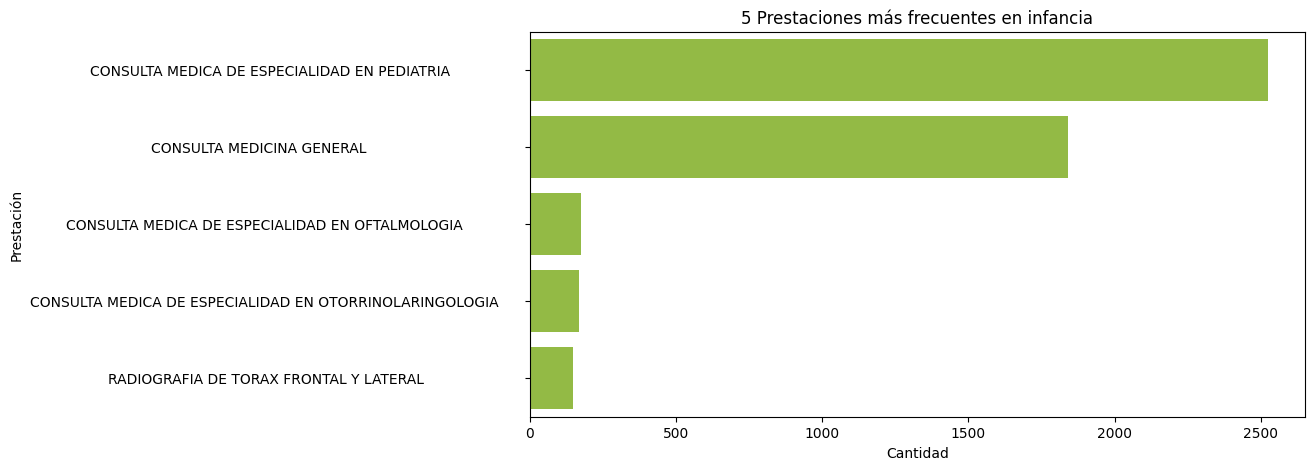

In [118]:
# Graficamos las 5 prestaciones más frecuentes del grupo1 niñez
plt.figure(figsize=(10, 5))
sns.countplot(data=grupo1, y='NOMBRE_PRESTACIÓN', order=grupo1['NOMBRE_PRESTACIÓN'].value_counts().index[:5], color='yellowgreen')
plt.title('5 Prestaciones más frecuentes en infancia')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

Las consultas médicas más frecuentes son:
- Consulta médica de especialidad en pediatría.
- Consulta médica general.
- Otras prestaciones incluyen especialidades en oftalmología y otorrinolaringología, así como radiografías de tórax frontal y lateral.

##### Grupo 2: 

In [119]:
# Filtramos las 5 prestaciones más frecuentes en el grupo2 adolescencia
grupo2['NOMBRE_PRESTACIÓN'].value_counts().head(5)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       1417
CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     426
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA      221
PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12              217
PSICOTERAPIA INDIVIDUAL                                          208
Name: count, dtype: int64

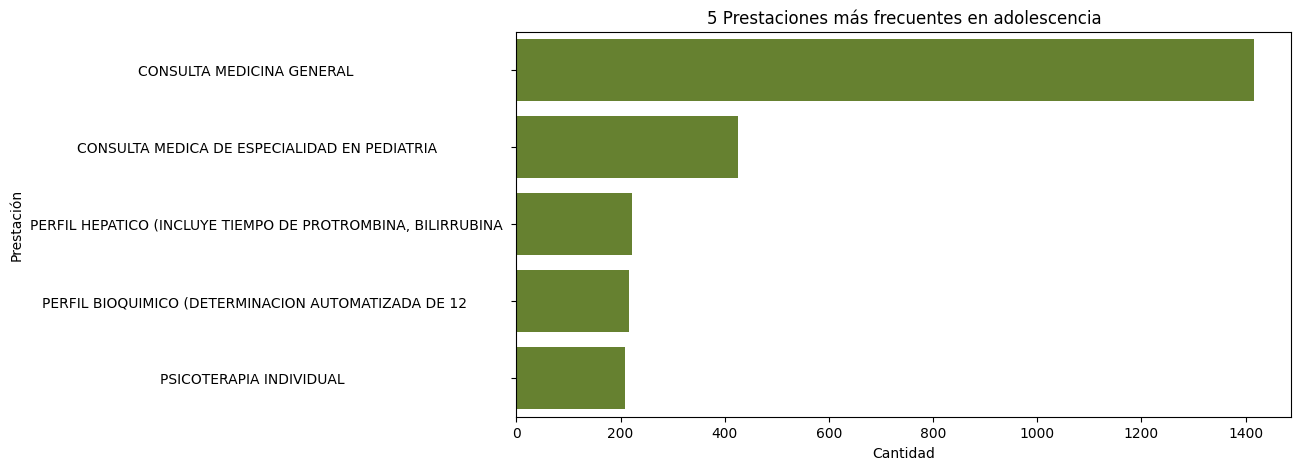

In [120]:
# Graficamos las 5 prestaciones más frecuentes del grupo2 adolescencia
plt.figure(figsize=(10, 5))
sns.countplot(data=grupo2, y='NOMBRE_PRESTACIÓN', order=grupo2['NOMBRE_PRESTACIÓN'].value_counts().index[:5], color='olivedrab')
plt.title('5 Prestaciones más frecuentes en adolescencia')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

- Predomina la consulta de medicina general.
- También es común la consulta médica pediátrica.
- Se realizan análisis como el perfil hepático y bioquímico, además de psicoterapia individual.


##### Grupo 3:

In [121]:
grupo3.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts().groupby('EDAD_TRAMO').head(3)

EDAD_TRAMO    NOMBRE_PRESTACIÓN                                           
20 a 24 años  CONSULTA MEDICINA GENERAL                                       1021
              CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     371
              PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12              192
25 a 29 años  CONSULTA MEDICINA GENERAL                                       1609
              CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     563
              PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12              237
30 a 34 años  CONSULTA MEDICINA GENERAL                                       1699
              CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     615
              VENOSA EN ADULTOS                                                250
35 a 39 años  CONSULTA MEDICINA GENERAL                                       1319
              CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     425
            

In [122]:
# Filtramos las 5 prestaciones más frecuentes en el grupo3 adultez
grupo3['NOMBRE_PRESTACIÓN'].value_counts().head(5)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       10361
CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     2889
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA      1908
PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12              1780
VENOSA EN ADULTOS                                                1731
Name: count, dtype: int64

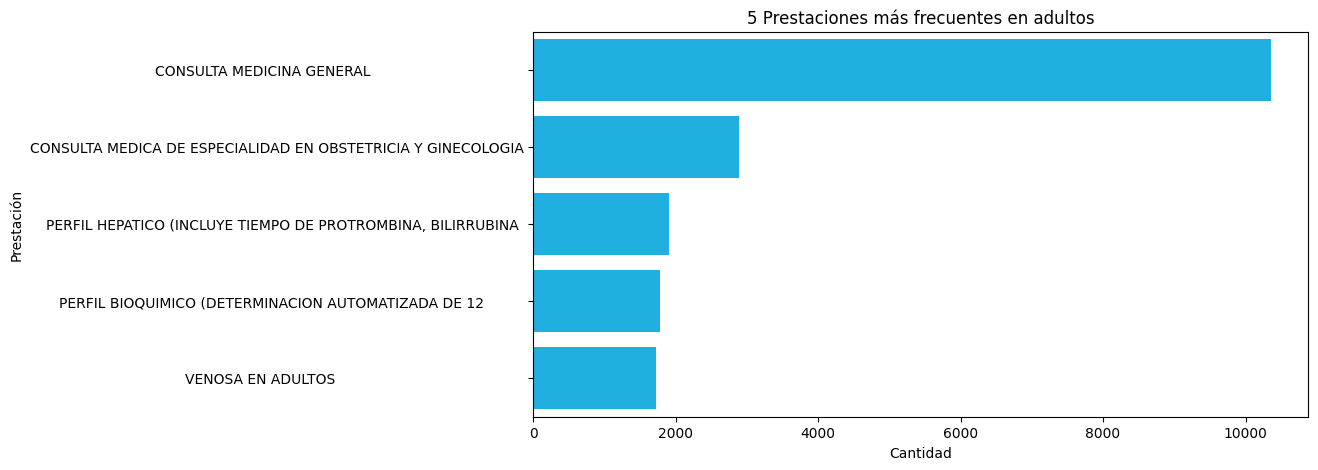

In [123]:
# Graficamos las 5 prestaciones más frecuentes del grupo3 adultez
plt.figure(figsize=(10, 5))
sns.countplot(data=grupo3, y='NOMBRE_PRESTACIÓN', order=grupo3['NOMBRE_PRESTACIÓN'].value_counts().index[:5], color='deepskyblue')
plt.title('5 Prestaciones más frecuentes en adultos')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

- La consulta de medicina general lidera ampliamente.
- Se destacan las especialidades en obstetricia y ginecología.
- Los análisis como perfil hepático y bioquímico son relevantes, junto con procedimientos venosos.

##### Grupo 4:

In [124]:
grupo4.groupby('EDAD_TRAMO')['NOMBRE_PRESTACIÓN'].value_counts().groupby('EDAD_TRAMO').head(3)

EDAD_TRAMO      NOMBRE_PRESTACIÓN                                           
60 a 64 años    CONSULTA MEDICINA GENERAL                                       938
                CONSULTA MEDICA DE ESPECIALIDAD EN TRAUMATOLOGIA Y ORTOPEDIA    292
                VENOSA EN ADULTOS                                               280
65 a 69 años    CONSULTA MEDICINA GENERAL                                       809
                VENOSA EN ADULTOS                                               282
                PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA     269
70 a 74 años    CONSULTA MEDICINA GENERAL                                       664
                VENOSA EN ADULTOS                                               247
                PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA     208
75 a 79 años    CONSULTA MEDICINA GENERAL                                       442
                VENOSA EN ADULTOS                                               207

In [125]:
# Filtramos las 5 prestaciones más frecuentes en el grupo4 vejez
grupo4['NOMBRE_PRESTACIÓN'].value_counts().head(5)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       3395
VENOSA EN ADULTOS                                               1245
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA     1099
CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                  943
PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12              943
Name: count, dtype: int64

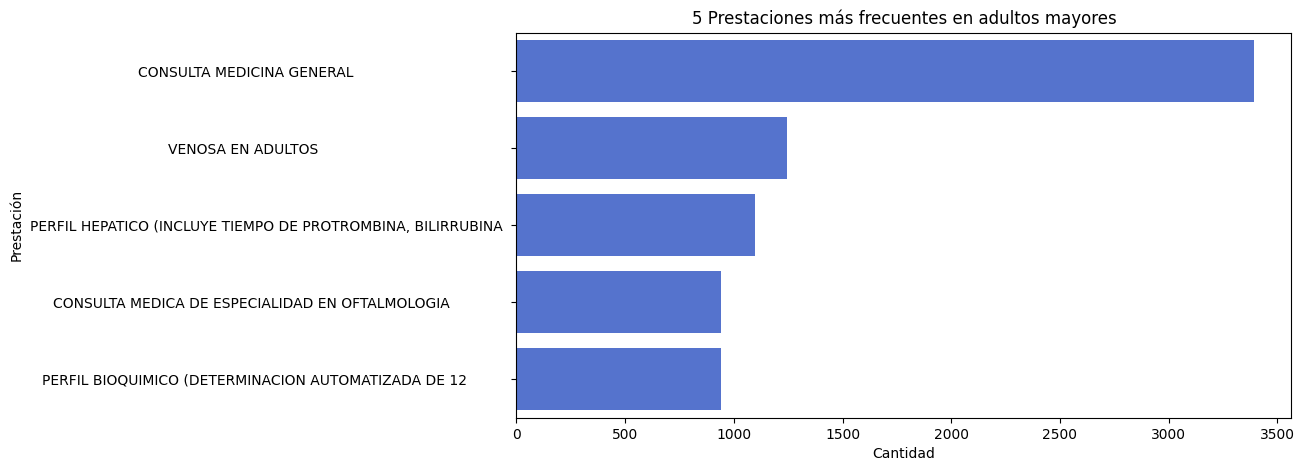

In [126]:
# Graficamos las 5 prestaciones más frecuentes del grupo etario de adultos mayores
plt.figure(figsize=(10, 5))
sns.countplot(data=grupo4, y='NOMBRE_PRESTACIÓN', order=grupo4['NOMBRE_PRESTACIÓN'].value_counts().index[:5], color='royalblue')
plt.title('5 Prestaciones más frecuentes en adultos mayores')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

- Al igual que en adultos, la consulta médica general es la prestación más frecuente.
- También se repiten las prestaciones de venosa en adultos y perfil hepático.
- Otras prestaciones incluyen especialidades en oftalmología y perfil bioquímico.

##### PRESTACIONES MÁS FRECUENTES POR GÉNERO:

In [127]:
# Tipos de prestación médica más frecuentes por género
mle_2023_df.groupby('SEXO')['NOMBRE_PRESTACIÓN'].value_counts()

SEXO    NOMBRE_PRESTACIÓN                                           
Hombre  CONSULTA MEDICINA GENERAL                                       6314
        CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    1551
        PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA     1220
        CONSULTA MEDICA DE ESPECIALIDAD EN TRAUMATOLOGIA Y ORTOPEDIA    1079
        PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12             1069
                                                                        ... 
Mujer   VARICES                                                            1
        VASCULOPATIA RETINAL (EXCEPTO RETINOPATIA PROLIFERATIVA)           1
        VIA LAGRIMAL, CATETERISMO O SONDAJE EN ADULTOS                     1
        VOLUMENES PULMONARES POR LAVADO DE NITROGENO                       1
        VULVECTOMIA SIMPLE                                                 1
Name: count, Length: 1339, dtype: int64

In [128]:
# 10 prestaciones más frecuentes por género femenino
mle_2023_df[mle_2023_df['SEXO'] == 'Mujer']['NOMBRE_PRESTACIÓN'].value_counts().head(10)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       10698
CONSULTA MEDICA DE ESPECIALIDAD EN OBSTETRICIA Y GINECOLOGIA     3349
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA      2089
VENOSA EN ADULTOS                                                2009
PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12              1985
CONSULTA MEDICA DE ESPECIALIDAD EN TRAUMATOLOGIA Y ORTOPEDIA     1649
CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                  1620
CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                     1399
25 OH VITAMINA D TOTAL POR INMUNOENSAYO                          1265
HEMOGRAMA (INCLUYE RECUENTOS DE LEUCOCITOS, ERITROCITOS,         1152
Name: count, dtype: int64

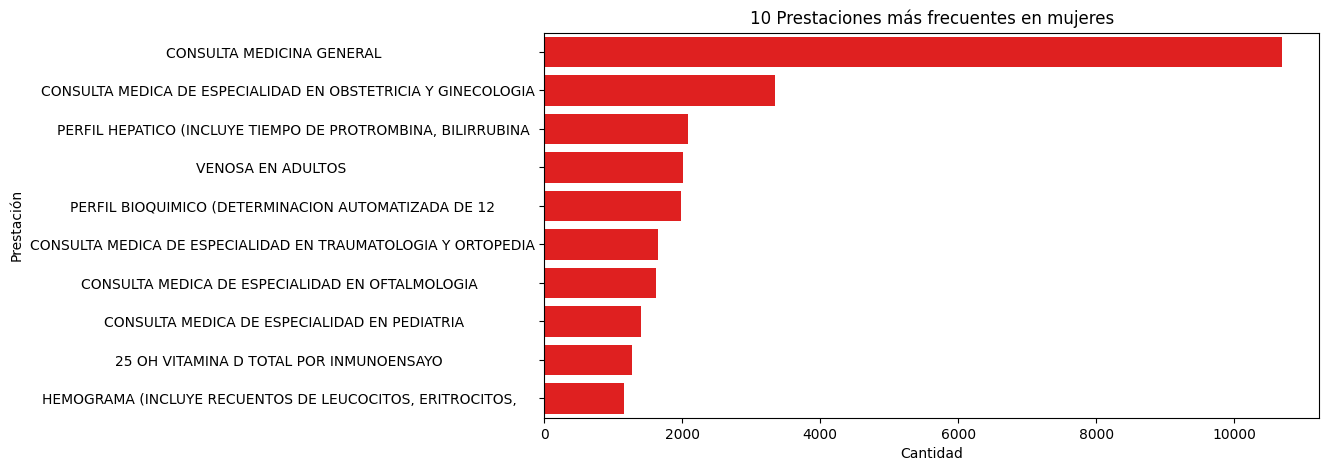

In [129]:
# Graficamos las 10 prestaciones más frecuentes del género femenino
plt.figure(figsize=(10, 5))
sns.countplot(data=mle_2023_df[mle_2023_df['SEXO'] == 'Mujer'], y='NOMBRE_PRESTACIÓN', order=mle_2023_df[mle_2023_df['SEXO'] == 'Mujer']['NOMBRE_PRESTACIÓN'].value_counts().index[:10], color='red')
plt.title('10 Prestaciones más frecuentes en mujeres')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

- Las mujeres tienen una mayor frecuencia de consulta médica general y consulta médica de especialidad en obstetricia y ginecología.
- También destacan los análisis de perfil hepático y perfil bioquímico.
- Se incluyen análisis como 25 OH vitamina D total y hemograma.

In [130]:
# 10 prestaciones más frecuentes por género masculino
mle_2023_df[mle_2023_df['SEXO'] == 'Hombre']['NOMBRE_PRESTACIÓN'].value_counts().head(10)

NOMBRE_PRESTACIÓN
CONSULTA MEDICINA GENERAL                                       6314
CONSULTA MEDICA DE ESPECIALIDAD EN PEDIATRIA                    1551
PERFIL HEPATICO (INCLUYE TIEMPO DE PROTROMBINA, BILIRRUBINA     1220
CONSULTA MEDICA DE ESPECIALIDAD EN TRAUMATOLOGIA Y ORTOPEDIA    1079
PERFIL BIOQUIMICO (DETERMINACION AUTOMATIZADA DE 12             1069
VENOSA EN ADULTOS                                               1058
CONSULTA MEDICA DE ESPECIALIDAD EN OFTALMOLOGIA                  979
CONSULTA MEDICA DE ESPECIALIDAD EN UROLOGIA                      964
ANTIGENO PROSTATICO ESPECIFICO                                   944
CREATININA EN SANGRE                                             627
Name: count, dtype: int64

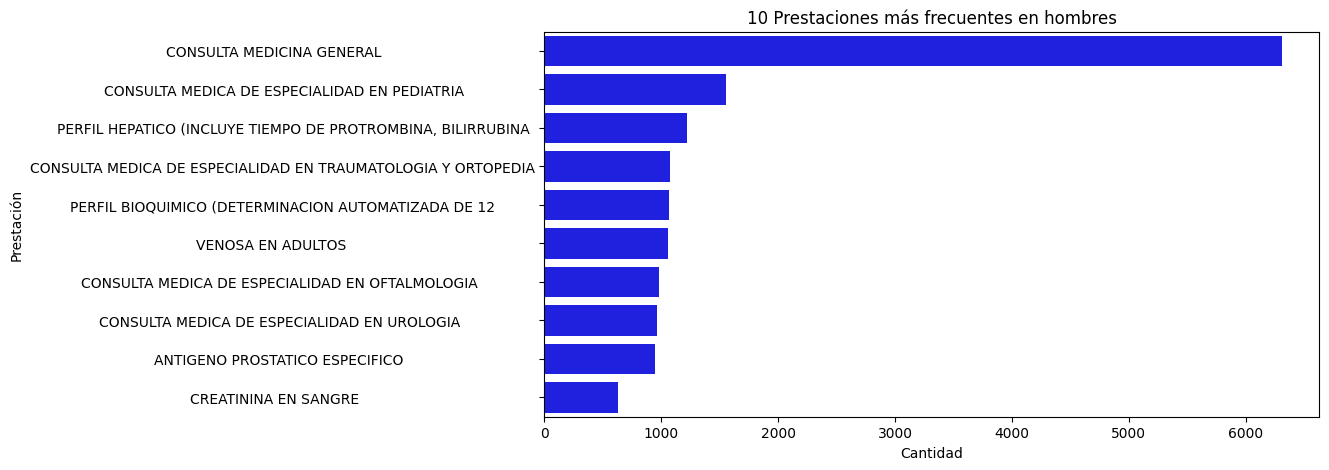

In [131]:
# Graficamos las 10 prestaciones más frecuentes del género masculino
plt.figure(figsize=(10, 5))
sns.countplot(data=mle_2023_df[mle_2023_df['SEXO'] == 'Hombre'], y='NOMBRE_PRESTACIÓN', order=mle_2023_df[mle_2023_df['SEXO'] == 'Hombre']['NOMBRE_PRESTACIÓN'].value_counts().index[:10], color='blue')
plt.title('10 Prestaciones más frecuentes en hombres')
plt.xlabel('Cantidad')
plt.ylabel('Prestación')
plt.show()

- En hombres, la consulta médica general ocupa la primera posición.
- La consulta médica de especialidad en pediatría también es común, seguida de análisis de perfil hepático, perfil bioquímico, y otras especialidades como traumatología y urología.
- Se mencionan análisis como antígeno prostático específico y creatinina en sangre.

#### Análisis general:

##### Edad
El análisis de las prestaciones médicas según el rango etario refleja patrones esperados basados en las necesidades de salud asociadas a cada etapa de la vida:

- En las edades más bajas, predominan las atenciones relacionadas con pediatría y consulta general, lo cual es coherente con el seguimiento del desarrollo infantil, la vacunación y la atención de enfermedades comunes en la infancia.
- La prestación de psicoterapia aparece exclusivamente en el grupo de adolescentes, lo que subraya la relevancia de abordar problemas emocionales y de salud mental en esta etapa crítica de desarrollo.
- Las prestaciones como consulta general, perfil hepático y perfil bioquímico se mantienen frecuentes en todos los grupos etarios. Esto puede explicarse por su uso en chequeos rutinarios o como parte de estrategias preventivas para monitorear la salud general de la población.

##### Género 
El análisis de la distribución de prestaciones médicas entre géneros evidencia diferencias notables:

- Las mujeres acceden a más atenciones médicas que los hombres, con una diferencia significativa en la prestación más demandada (10,000 atenciones para mujeres frente a 6,000 para hombres en el top 1).
- Las prestaciones de obstetricia y ginecología son claramente predominantes en las mujeres, lo que refleja necesidades relacionadas con la salud reproductiva y materna.
- El perfil hepático, asociado a chequeos generales o diagnósticos específicos, resulta una prestación común entre ambos géneros, lo que indica su relevancia en el monitoreo de la salud hepática independientemente del género.
- En el caso de pediatría, se observa una mayor cantidad de consultas para hombres que para mujeres. Este patrón podría estar vinculado a diferencias biológicas, sociales o culturales en el acceso o la demanda de estos servicios para niños y niñas.

## 2. ¿Cómo varía la cantidad y tipo de prestaciones emitidas según el mes del año? ¿Existen patrones estacionales?

## 3. ¿Qué tipos de prestación médica son más frecuentes en cada región?

**Aclaraciones**  

- Usaremos el archivo **Regional.shp** para graficar el mapa de Chile, con las regiones delimitadas.
  
- Utilizaremos la librería **fuzzywuzzy** (específicamente `from fuzzywuzzy import process`) para hacer coincidir los nombres de regiones en el DataFrame **mle_2023_df** con los nombres presentes en el shapefile **mapa**.


### Introduccion

La salud es un aspecto fundamental para cualquier sociedad, y entender cómo se distribuyen las prestaciones médicas en un país como Chile puede revelar patrones clave. Por ello, en este análisis buscamos identificar los tipos de prestaciones médicas más frecuentes en cada región. Para lograrlo, utilizamos un conjunto de datos que incluye información sobre prestaciones, regiones de emisión y su frecuencia de uso.

**Elección de variables**  

Para analizar los tipos de prestaciones médicas más frecuentes en cada región, hemos seleccionado las siguientes variables:

1. REGION_EMISION: Esta variable es fundamental, ya que nos permite identificar la región de emisión de cada prestación médica, lo cual es clave para realizar el análisis por región.

2. NOMBRE_PRESTACIÓN: Esta variable describe el tipo de prestación médica (por ejemplo, consultas, procedimientos quirúrgicos, etc.). Nos proporciona la categoría de la prestación, lo que nos permite segmentar el análisis según el tipo de servicio médico.

3. FRECUENCIA: Usamos esta variable para conocer cuántas veces se ha realizado cada tipo de prestación médica en cada región. Esto nos permitirá identificar las prestaciones más comunes en cada región.

In [132]:
# Agrupar por región y tipo de prestación
prestaciones_por_region = mle_2023_df.groupby(['REGION_EMISION', 'NOMBRE_PRESTACIÓN']).size().reset_index(name='FRECUENCIA')

In [133]:
# Ordenar por región y frecuencia descendente
prestaciones_por_region = prestaciones_por_region.sort_values(['REGION_EMISION', 'FRECUENCIA'], ascending=[True, False])

In [134]:
prestaciones_mas_frecuentes = prestaciones_por_region.groupby('REGION_EMISION').first().reset_index()

In [135]:
prestaciones_mas_frecuentes

,REGION_EMISION,NOMBRE_PRESTACIÓN,FRECUENCIA
0,De Antofagasta,CONSULTA MEDICINA GENERAL ...,618
1,De Arica Y Parinacota,CONSULTA MEDICINA GENERAL ...,96
2,De Atacama,CONSULTA MEDICINA GENERAL ...,219
3,De Aysén Del Gral. C. Ibáñez Del Campo,CONSULTA MEDICINA GENERAL ...,14
4,De Coquimbo,CONSULTA MEDICINA GENERAL ...,875
5,De La Araucanía,CONSULTA MEDICINA GENERAL ...,500
6,De Los Lagos,CONSULTA MEDICINA GENERAL ...,801
7,De Los Ríos,CONSULTA MEDICINA GENERAL ...,348
8,De Magallanes Y De La Antártica Chilena,CONSULTA MEDICINA GENERAL ...,114
9,De Tarapacá,CONSULTA MEDICINA GENERAL ...,257


**Distribución de los datos**  

En primera instancia, veremos la distribución de los datos por región, específicamente los tipos de prestación médica más frecuentes en cada una.


C:\Users\barba\AppData\Local\Temp\ipykernel_7568\1012203669.py:2: UserWarning: The palette list has more values (8) than needed (1), which may not be intended.
  sns.barplot(data=prestaciones_mas_frecuentes, x='REGION_EMISION', y='FRECUENCIA', hue='NOMBRE_PRESTACIÓN', dodge=False, palette=sns.color_palette("hls", 8))


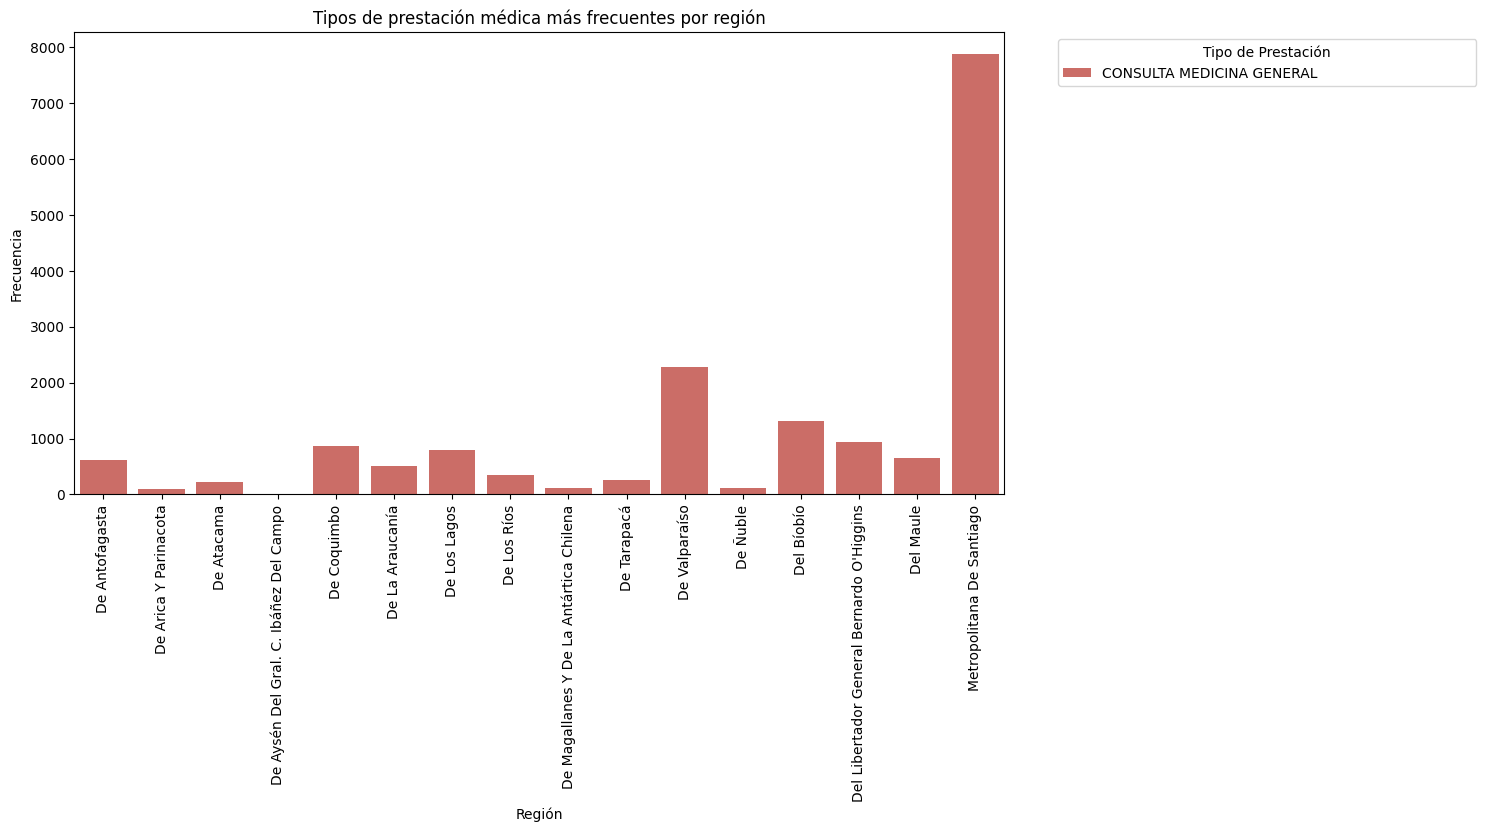

In [136]:
plt.figure(figsize=(12, 6))
sns.barplot(data=prestaciones_mas_frecuentes, x='REGION_EMISION', y='FRECUENCIA', hue='NOMBRE_PRESTACIÓN', dodge=False, palette=sns.color_palette("hls", 8))
plt.title('Tipos de prestación médica más frecuentes por región')
plt.xlabel('Región')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo de Prestación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.show()

 A continuación, se presenta un gráfico de barras donde se muestra la frecuencia de cada tipo de prestación médica en función de la región. El eje X representa las regiones de emisión, mientras que el eje Y indica la frecuencia de cada tipo de prestación. Los colores en las barras corresponden a los distintos tipos de prestaciones médicas, facilitando la visualización de cuál es más común en cada región.

**Análisis del Gráfico**

En este análisis, la prestación médica más frecuente en todas las regiones es la "CONSULTA MÉDICA GENERAL". Sin embargo, aunque esta prestación se repite en todas las regiones, las frecuencias varían, con algunas regiones presentando una mayor cantidad de consultas que otras.

**Distribución geográfica de los datos**

En segunda instancia, mostraremos geográficamente la frecuencia de las prestaciones médicas por región. Utilizaremos el shapefile con la información geográfica de Chile y el dataframe con los datos de las prestaciones más frecuentes, emparejando las regiones utilizando la librería fuzzywuzzy para asegurar que los nombres coincidan correctamente. 

In [137]:
# de usa este archivo para poder graficar el mapa de Chile por regiones
mapa = gpd.read_file("../data/Regiones/Regional.shp")
mapa

,objectid,cir_sena,codregion,area_km,st_area_sh,st_length_,Region,geometry
0,1084,1,15,16866.819844,1.886869e+10,7.505296e+05,Región de Arica y Parinacota,"POLYGON ((-7727277.278 -1997230.768, -7726464...."
1,1085,2,1,42284.567484,4.830637e+10,1.213713e+06,Región de Tarapacá,"MULTIPOLYGON (((-7810213.515 -2298008.28, -781..."
2,1086,3,2,126071.431981,1.508452e+11,2.516112e+06,Región de Antofagasta,"MULTIPOLYGON (((-7870470.961 -2985679.186, -78..."
3,1087,15,12,133053.142345,3.581316e+11,9.049830e+07,Región de Magallanes y Antártica Chilena,"MULTIPOLYGON (((-7494057.535 -7542535.383, -74..."
4,1088,14,11,106703.377369,2.242743e+11,4.144481e+07,Región de Aysén del Gral.Ibañez del Campo,"MULTIPOLYGON (((-8413517.696 -6234055.255, -84..."
5,1089,4,3,75661.248635,9.643906e+10,2.401741e+06,Región de Atacama,"MULTIPOLYGON (((-7932747.768 -3311218.615, -79..."
6,1090,5,4,40575.901682,5.498082e+10,2.065933e+06,Región de Coquimbo,"MULTIPOLYGON (((-7963268.9 -3784870.143, -7963..."
7,1091,6,5,16322.970393,2.301475e+10,1.679609e+06,Región de Valparaíso,"MULTIPOLYGON (((-8991645.917 -3991821.789, -89..."
8,1092,7,13,15392.030737,2.225204e+10,1.064253e+06,Región Metropolitana de Santiago,"POLYGON ((-7873736.745 -3885505.642, -7873695...."
9,1093,13,10,48408.371357,8.771834e+10,7.874158e+06,Región de Los Lagos,"MULTIPOLYGON (((-8331768.181 -5403721.402, -83..."


Para emparejar nombres similares, utilizamos la librería [fuzzywuzzy](https://stackoverflow.com/questions/41171665/python-fuzzywuzzys-process-extract-how-does-it-work), específicamente la función `process.extractOne()`, que nos permite buscar la coincidencia más cercana entre cadenas de texto. En este caso, la utilizaremos para emparejar los nombres de las regiones entre el dataframe `beneficiarios_df` y el shapefile `mapa`.


<Figure size 1200x800 with 0 Axes>

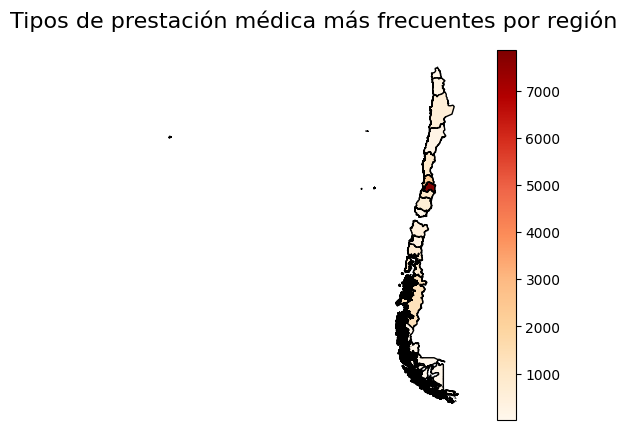

In [138]:
# Emparejar nombres similares
nombres_mapa = mapa['Region'].unique()
nombres_prestaciones = prestaciones_mas_frecuentes['REGION_EMISION'].unique()

# Crear un diccionario de coincidencias
matches = {nombre: process.extractOne(nombre, nombres_mapa)[0] for nombre in nombres_prestaciones}

# Reemplazar nombres en prestaciones_mas_frecuentes
prestaciones_mas_frecuentes['Region'] = prestaciones_mas_frecuentes['REGION_EMISION'].map(matches)

# Unir con el shapefile
mapa_regiones = mapa.merge(prestaciones_mas_frecuentes, on='Region', how='left')

plt.figure(figsize=(12, 8))
mapa_regiones.plot(column='FRECUENCIA', cmap='OrRd', legend=True, edgecolor='black')
plt.title('Tipos de prestación médica más frecuentes por región', fontsize=16)
plt.axis('off')
plt.show()

A continuación, se presenta un mapa geográfico donde se visualiza la frecuencia de las prestaciones médicas más comunes por región. En este mapa, las regiones están representadas mediante colores que indican la frecuencia de la prestación médica más frecuente en cada una. Las regiones con colores más intensos muestran una mayor frecuencia, lo que facilita la comparación visual de las diferencias en la distribución de las prestaciones médicas a lo largo del país.

**Análisis del Gráfico**

En este análisis, por ejemplo, la Región Metropolitana de Santiago presenta la mayor cantidad de consultas, mientras que otras regiones, como Aysén del Gral. C. Ibáñez del Campo, tienen frecuencias considerablemente más bajas. Esta diferencia en las frecuencias refleja la diversidad en la distribución y demanda de servicios médicos a lo largo del país.

### Conclusion

En este análisis, se exploró la frecuencia de las prestaciones médicas más comunes en diversas regiones del país, utilizando tanto un gráfico de barras como un mapa geográfico para visualizar los resultados. Se identificó que la prestación médica más frecuente en todas las regiones es la "Consulta Médica General", aunque las frecuencias varían significativamente entre las regiones. La Región Metropolitana de Santiago, por ejemplo, presenta la mayor cantidad de consultas, mientras que otras regiones, como Aysén del Gral. C. Ibáñez del Campo, muestran una demanda mucho menor.

Este patrón de distribución refleja no solo las diferencias en el acceso y la demanda de servicios médicos, sino también posibles disparidades regionales en infraestructura y atención sanitaria. Las regiones más urbanizadas tienden a tener una mayor concentración de consultas, mientras que las zonas más alejadas podrían enfrentar desafíos relacionados con la disponibilidad y el acceso a estos servicios.

En resumen, este análisis destaca la importancia de considerar las diferencias regionales en el acceso a la atención médica y la necesidad de políticas públicas que aborden estas desigualdades para mejorar la cobertura y la calidad de los servicios de salud en todo el país.

## 4. ¿Cómo se relacionan los distintos tramos de Fonasa con la frecuencia y el tipo de prestaciones recibidas?

In [139]:
# Calcular la frecuencia total de prestaciones por tramo Fonasa
cant_por_tramo = mle_2023_df.groupby("TRAMO_FONASA")["PRESTACIONES"].sum().reset_index()

cant_por_tramo.columns = ["Tramo Fonasa", "Total Prestaciones"]

print(cant_por_tramo)

  Tramo Fonasa  Total Prestaciones
0            A                28.0
1            B             55262.0
2            C             20508.0
3            D             45021.0
4            X               588.0


In [140]:
# Agrupar por tramo y tipo de prestación (sección)
tipo_por_tramo = mle_2023_df.groupby(["TRAMO_FONASA", "DESC_SECCION"])["PRESTACIONES"].sum().reset_index()

# Sorteamos
tipo_por_tramo = tipo_por_tramo.sort_values(["TRAMO_FONASA", "PRESTACIONES"], ascending=[True, False])

tipo_por_tramo.head()

,TRAMO_FONASA,DESC_SECCION,PRESTACIONES
0,A,Atención Médica,16.0
1,A,Exámenes De Diagnóstico,10.0
2,A,Intervenciones Quirúrgicas,1.0
3,A,Proc. Apoyo Clínico Y Terap.,1.0
7,B,Exámenes De Diagnóstico,25904.0


In [141]:
# Agrupar por tramo Fonasa y edad
distribucion_edad = beneficiarios_df.groupby(["TRAMO_FONASA", "EDAD_TRAMO"]).size().reset_index(name="Count")

distribucion_edad.head()

,TRAMO_FONASA,EDAD_TRAMO,Count
0,A,0 a 9 años,3520
1,A,10 a 19 años,5034
2,A,20 a 29 años,1826
3,A,30 a 39 años,1940
4,A,40 a 49 años,1778


In [142]:
# Agrupar por tramo Fonasa y sexo
distribucion_genero = beneficiarios_df.groupby(["TRAMO_FONASA", "SEXO"]).size().reset_index(name="Count")

print(distribucion_genero)

  TRAMO_FONASA             SEXO  Count
0            A           Hombre   7475
1            A            Mujer  10127
2            A  Sin información      1
3            B           Hombre  17841
4            B            Mujer  23804
5            B  Sin información      1
6            C           Hombre   8605
7            C            Mujer   7933
8            D           Hombre  13787
9            D            Mujer  10426


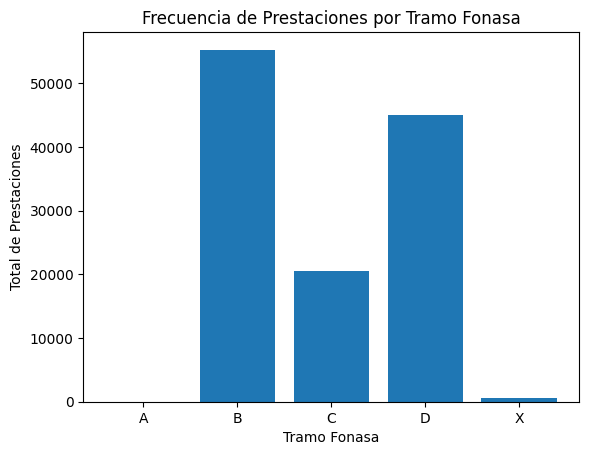

In [143]:
import matplotlib.pyplot as plt

plt.bar(cant_por_tramo["Tramo Fonasa"], cant_por_tramo["Total Prestaciones"])
plt.title("Frecuencia de Prestaciones por Tramo Fonasa")
plt.xlabel("Tramo Fonasa")
plt.ylabel("Total de Prestaciones")
plt.show()

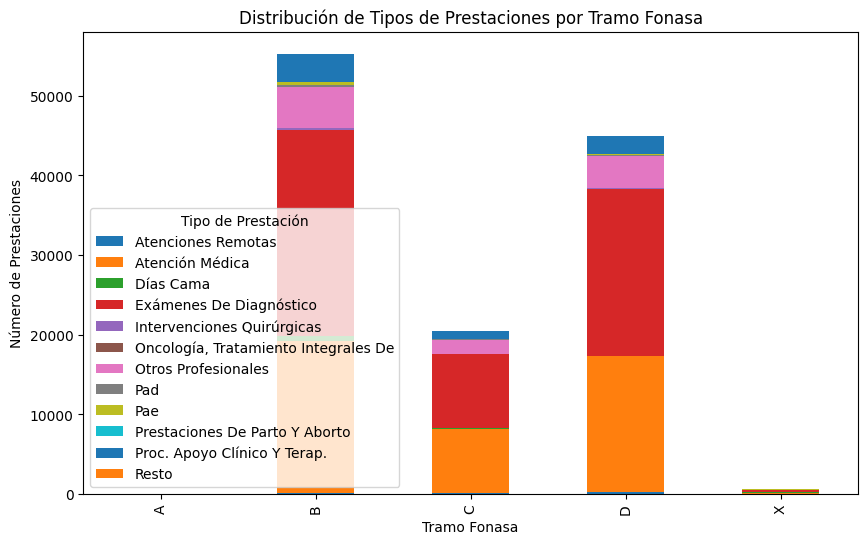

In [144]:
# Gráfico apilado para tipos de prestaciones por tramo
type_pivot = tipo_por_tramo.pivot(index="TRAMO_FONASA", columns="DESC_SECCION", values="PRESTACIONES")
type_pivot.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.title("Distribución de Tipos de Prestaciones por Tramo Fonasa")
plt.xlabel("Tramo Fonasa")
plt.ylabel("Número de Prestaciones")
plt.legend(title="Tipo de Prestación")
plt.show()

In [145]:
# Calcular la frecuencia total de prestaciones por tramo Fonasa
cant_por_tramo = mle_2023_df.groupby("TRAMO_FONASA")["PRESTACIONES"].sum().reset_index()
cant_por_tramo.columns = ["Tramo Fonasa", "Total Prestaciones"]

tipo_por_tramo = mle_2023_df.groupby(["TRAMO_FONASA", "DESC_SECCION"])["PRESTACIONES"].sum().reset_index()

tipo_por_tramo = tipo_por_tramo.sort_values(["TRAMO_FONASA", "PRESTACIONES"], ascending=[True, False])

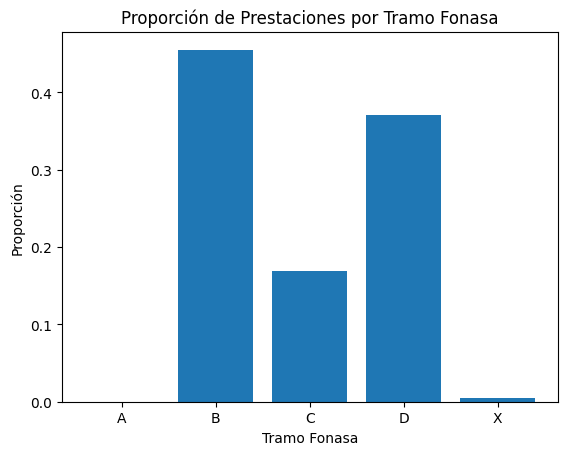

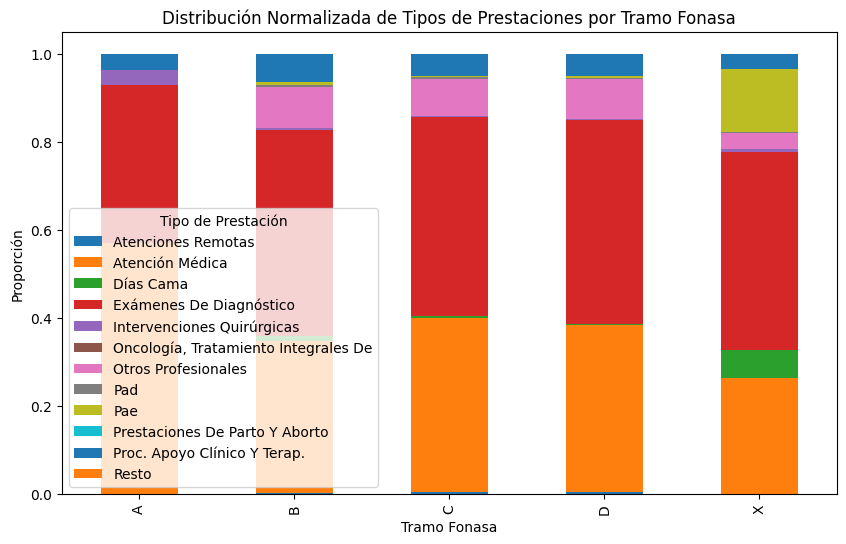

In [146]:
# Normalizar frecuencia total de prestaciones por tramo
cant_por_tramo["Proporción"] = cant_por_tramo["Total Prestaciones"] / cant_por_tramo["Total Prestaciones"].sum()

# Normalizar tipos de prestaciones por tramo
tipo_por_tramo["Proporción"] = tipo_por_tramo.groupby("TRAMO_FONASA")["PRESTACIONES"].transform(lambda x: x / x.sum())

plt.bar(cant_por_tramo["Tramo Fonasa"], cant_por_tramo["Proporción"])
plt.title("Proporción de Prestaciones por Tramo Fonasa")
plt.xlabel("Tramo Fonasa")
plt.ylabel("Proporción")
plt.show()

type_pivot_normalized = tipo_por_tramo.pivot(index="TRAMO_FONASA", columns="DESC_SECCION", values="Proporción")
type_pivot_normalized.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.title("Distribución Normalizada de Tipos de Prestaciones por Tramo Fonasa")
plt.xlabel("Tramo Fonasa")
plt.ylabel("Proporción")
plt.legend(title="Tipo de Prestación")
plt.show()  

## 5. ¿Cómo cambia el gasto promedio en copagos a medida que los beneficiarios envejecen?